<a href="https://colab.research.google.com/github/mohanrajventuri17/FMML_PROJECTS_AND_LABS/blob/main/Module_01_Lab_03_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [2]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels

11490434/11490434 [==============================] - 0s 0us/step


Let us borrow a few functions from the previous labs:

In [3]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [4]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

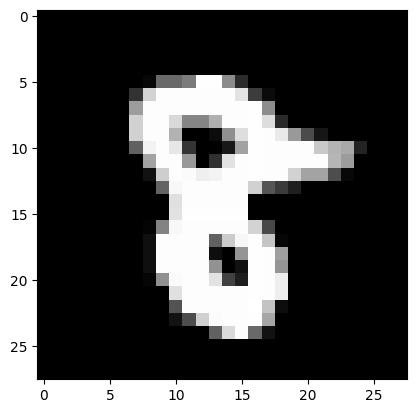

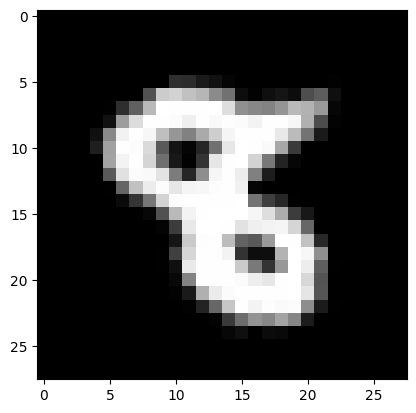

In [5]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [6]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

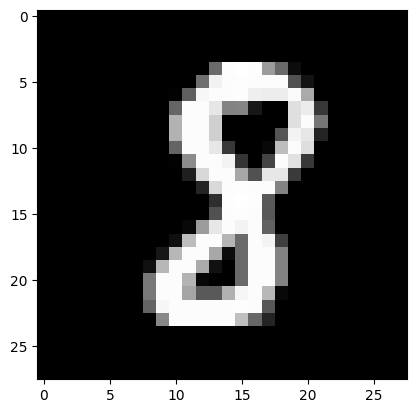

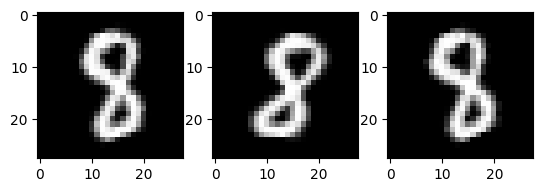

In [7]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [8]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6616


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [9]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-9-2f14d3721156>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here


Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6727
Accuracy after rotation augmentation constrained by  20  is  0.673
Accuracy after rotation augmentation constrained by  30  is  0.6737
Accuracy after rotation augmentation constrained by  40  is  0.6731
Accuracy after rotation augmentation constrained by  50  is  0.6701
Accuracy after rotation augmentation constrained by  60  is  0.6675
Accuracy after rotation augmentation constrained by  70  is  0.661
Accuracy after rotation augmentation constrained by  80  is  0.6462
Accuracy after rotation augmentation constrained by  90  is  0.6469


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

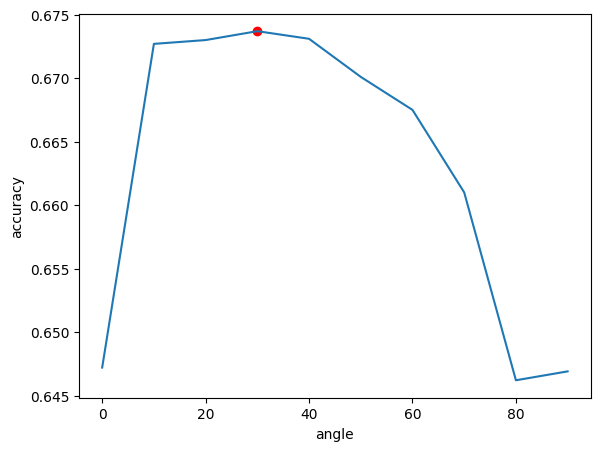

In [10]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [11]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

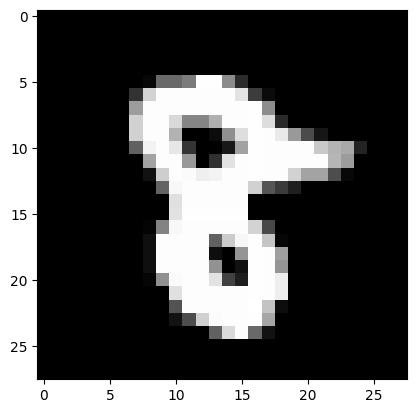

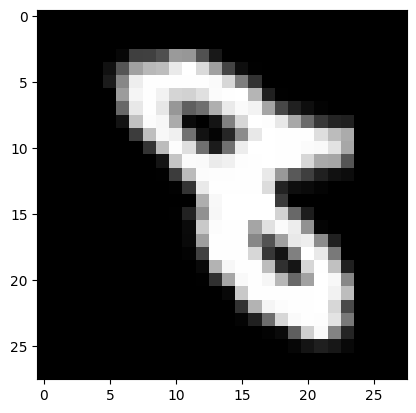

In [12]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [13]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [14]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-14-8a89fef4983d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here


Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6147
Accuracy after shear augmentation constrained by  0.4  is  0.632
Accuracy after shear augmentation constrained by  0.6  is  0.6351
Accuracy after shear augmentation constrained by  0.8  is  0.6636
Accuracy after shear augmentation constrained by  1.0  is  0.6652
Accuracy after shear augmentation constrained by  1.2  is  0.6495
Accuracy after shear augmentation constrained by  1.4  is  0.6181
Accuracy after shear augmentation constrained by  1.6  is  0.6323
Accuracy after shear augmentation constrained by  1.8  is  0.6432
Accuracy after shear augmentation constrained by  2.0  is  0.6277


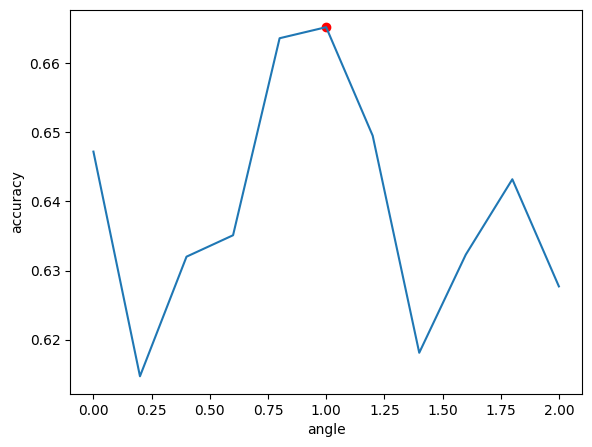

In [15]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [16]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [17]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

<ipython-input-17-09de780976d0>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here


Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6151
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.5997
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.5915
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6198
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6031
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.5916
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.634
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.5991
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6044
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6358
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.5827
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.579
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.5877
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6344
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.61

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

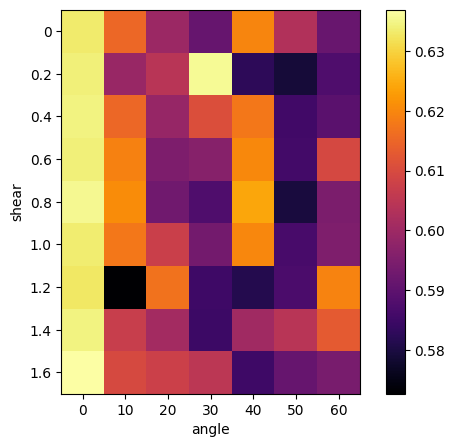

In [18]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

***1)Ans***
 The best values for angle and shear constraints in data augmentation depend on the specific machine learning task and dataset you are working with. There is no one-size-fits-all answer to this question, as the optimal values can vary based on factors such as the nature of the data, the complexity of the model, and the problem you are trying to solve. The choice of augmentation parameters should be determined through experimentation and validation.

In general, data augmentation techniques like rotation (angle constraint) and shear can help improve the generalization and robustness of machine learning models by providing them with a more diverse set of training examples. These augmentations can help the model learn to recognize patterns from different angles and perspectives.

To find the optimal values for angle and shear constraints, you can perform the following steps:

1. **Initial Experimentation**: Start with a range of values for angle and shear constraints. For example, you can try angles between -10 degrees and 10 degrees and shear factors between 0.1 and 0.3.

2. **Validation**: Split your dataset into training, validation, and test sets. Train your machine learning model on the augmented training data while using the validation set to evaluate model performance.

3. **Hyperparameter Tuning**: Use techniques like grid search or random search to systematically explore different combinations of augmentation parameters along with other hyperparameters of your model.

4. **Compare Results**: Measure the performance metrics (e.g., accuracy, F1 score) on the validation set for each set of augmentation parameters.

5. **Select Best Parameters**: Choose the combination of augmentation parameters that results in the best performance on the validation set.

6. **Evaluate on Test Set**: Finally, evaluate the model with the selected augmentation parameters on a separate test set to estimate its real-world performance.

The improvement in accuracy due to data augmentation will vary depending on the dataset and task. In some cases, data augmentation can lead to significant improvements in model performance, especially when the original dataset is limited or unbalanced. However, in other cases where the original dataset is already large and diverse, the improvement may be marginal.

To quantify the impact of data augmentation, you can compare the accuracy of the model with augmentation to the accuracy of the model trained on the original, unaugmented data. The improvement in accuracy will be specific to your dataset and task and should be assessed through rigorous experimentation.

***2)Ans***
 Increasing the number of augmentations from each sample can potentially improve the accuracy of your machine learning model, but it also comes with trade-offs and considerations.

Pros:
1. **Increased Data Diversity**: Augmenting each sample multiple times creates more diverse training data. This added diversity can help the model generalize better to variations in the test data, leading to improved accuracy.

2. **Robustness**: Models trained on augmented data may become more robust to noise, small variations, or different viewpoints, which can enhance their real-world performance.

Cons:
1. **Risk of Overfitting**: Augmenting each sample excessively can lead to overfitting, where the model becomes too specialized in recognizing variations present in the training data but fails to generalize well to new, unseen data. This is especially a concern when the augmented data closely resembles the original data.

2. **Increased Computational Load**: Augmenting each sample multiple times increases the computational load during training. This can result in longer training times and require more computational resources.

3. **Diminishing Returns**: There may be diminishing returns with increasing the number of augmentations. Beyond a certain point, additional augmentations may not significantly improve model performance, and the effort and resources required may not be justified.

To make the most of increasing the number of augmentations, consider the following best practices:

1. **Regularization**: To mitigate the risk of overfitting, use regularization techniques such as dropout or L2 regularization in conjunction with data augmentation.

2. **Monitor Validation Performance**: Continuously monitor the model's performance on a validation set as you increase the number of augmentations. If you notice diminishing or negative returns, it may be an indication that you are overdoing it.

3. **Balance**: Strike a balance between augmenting each sample and the size of your training dataset. If your dataset is already large and diverse, you may not need to apply excessive augmentations.

4. **Randomization**: When applying multiple augmentations to the same sample, consider adding randomness to the augmentation process. This can help ensure that each augmented version of the sample is slightly different, reducing the risk of overfitting.

5. **Experiment and Validate**: As always, experiment and validate your approach. The optimal number of augmentations may vary depending on your specific dataset and machine learning task.

In summary, increasing the number of augmentations from each sample can be a useful technique to enhance model performance, but it should be applied judiciously, and careful monitoring of model performance and the risk of overfitting is essential.

***3)Ans***
 Here's a simple example of how you can perform image augmentations using PyTorch:


In [26]:
# importing all the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt

(168, 300, 3)


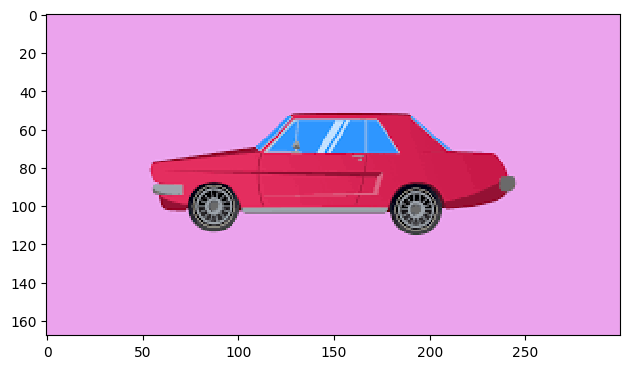

In [28]:
# reading the image using its path
image = io.imread('/content/download.png')

# shape of the image
print(image.shape)

# displaying the image
io.imshow(image)

Rotated Image


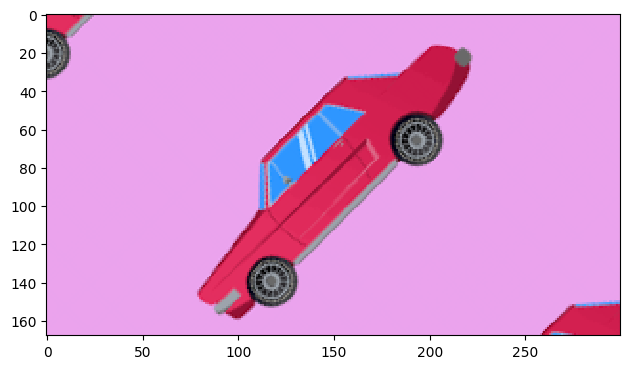

In [29]:
print('Rotated Image')
#rotating the image by 45 degrees
rotated = rotate(image, angle=45, mode = 'wrap')
#plot the rotated image
io.imshow(rotated)

**Shifting Images**

There might be scenarios when the objects in the image are not perfectly central aligned. In these cases, image shift can be used to add shift-invariance to the images.

By shifting the images, we can change the position of the object in the image and hence give more variety to the model. This will eventually lead to a more generalized model.

Image shift is a geometric transformation that maps the position of every object in the image to a new location in the final output image.

After the shift operation, an object present at a location (x,y) in the input image is shifted to a new position (X, Y):

X = x + dx
Y = y + dy
Here, dx and dy are the respective shifts along different dimensions. Let’s see how we can apply shift to an image:

Text(0.5, 1.0, 'Wrap Shift')

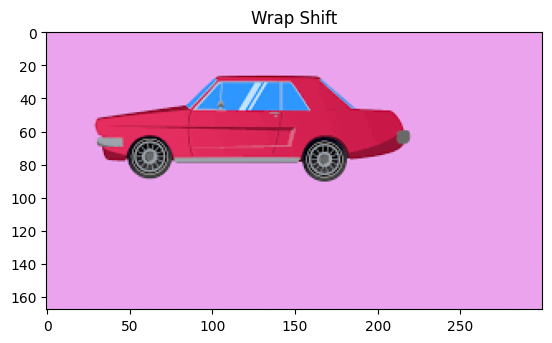

In [30]:
#apply shift operation
transform = AffineTransform(translation=(25,25))
wrapShift = warp(image,transform,mode='wrap')
plt.imshow(wrapShift)
plt.title('Wrap Shift')

**Flipping Images**

Flipping is an extension of rotation. It allows us to flip the image in the left-right as well as up-down direction. Let’s see how we can implement flipping:

Text(0.5, 1.0, 'Left to Right Flipped')

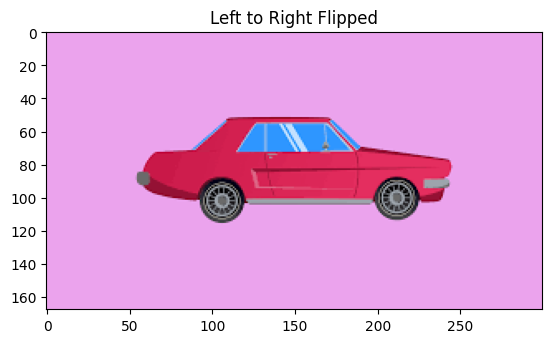

In [31]:
#flip image left-to-right
flipLR = np.fliplr(image)

plt.imshow(flipLR)
plt.title('Left to Right Flipped')

Here, I have used the fliplr function of NumPy to flip the image from left to right. It flips the pixel values of each row and the output confirms the same. Similarly, we can flip the images in an up-down direction:

Text(0.5, 1.0, 'Up Down Flipped')

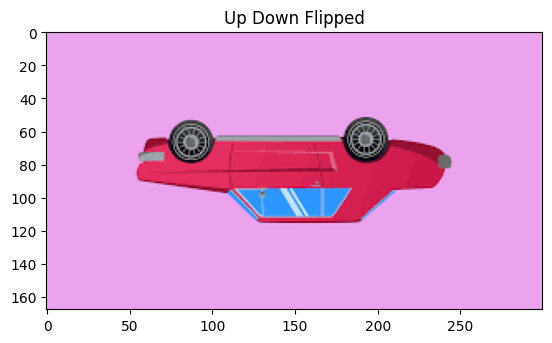

In [32]:
#flip image up-to-down
flipUD = np.flipud(image)

plt.imshow(flipUD)
plt.title('Up Down Flipped')

**Adding Noise to Images**

Image noising is an important augmentation step that allows our model to learn how to separate signal from noise in an image. This also makes the model more robust to changes in the input.

We will use the random_noise function of the skimage library to add some random noise to our original image.

I will take the standard deviation of the noise to be added as 0.155 (you can change this value as well). Just keep in mind that increasing this value will add more noise to the image and vice versa:

Text(0.5, 1.0, 'Random Noise')

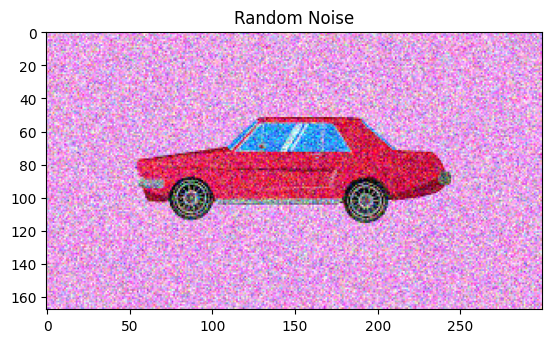

In [33]:
#standard deviation for noise to be added in the image
sigma=0.155
#add random noise to the image
noisyRandom = random_noise(image,var=sigma**2)

plt.imshow(noisyRandom)
plt.title('Random Noise')

**Blurring Images**

All photography lovers will instantly understand this idea.

Images come from different sources. And hence, the quality of the images will not be the same from each source. Some images might be of very high quality while others might be just plain bad.

In such scenarios, we can blur the image. How will that help? Well, this helps make our deep learning model more robust.

Let’s see how we can do that. We will use a Gaussian filter for blurring the image:

Text(0.5, 1.0, 'Blurred Image')

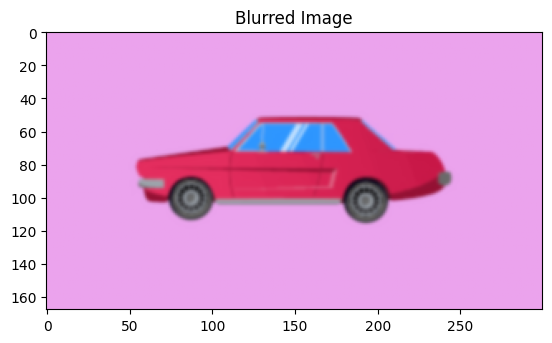

In [34]:
#blur the image
blurred = gaussian(image,sigma=1,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')

Sigma here is the standard deviation for the Gaussian filter. I have taken it as 1. The higher the sigma value, the more will be the blurring effect. Setting Multichannel to true ensures that each channel of the image is filtered separately.

Again, you can try different sigma values to change the magnitude of blurriness.

These are some of the image augmentation techniques which help to make our deep learning model robust and generalizable. This also helps increase the size of the training set.

We’re almost at the implementation part of this tutorial. Before that, let’s look at some of the basic guidelines for deciding the right image augmentation technique.



***4)Ans***
 Achieving the highest accuracy and determining the smallest training dataset size needed to achieve an accuracy above 50% depends on various factors, including the specific dataset, model architecture, and the quality of augmentations applied. Here's a general approach to experiment and find the highest accuracy and the minimum dataset size:

1. **Dataset and Model Selection**: Choose a suitable dataset and model architecture for your task. For this example, let's assume you're working with a well-known dataset like CIFAR-10 and a convolutional neural network (CNN) architecture.

2. **Data Augmentation**: Apply a combination of data augmentations to your training dataset. Common augmentations include random rotation, horizontal flip, random crop, and color jitter, among others. You can use the torchvision.transforms module in PyTorch for this purpose.

3. **Training Loop**: Set up a training loop where you train your model using the augmented dataset. Use a validation set to monitor model performance and prevent overfitting.

4. **Experimentation**:
   - Start with a moderate dataset size (e.g., 10% of the full dataset) and a reasonable combination of augmentations.
   - Train your model and evaluate its accuracy on the validation set.
   - Experiment with different combinations of augmentations, hyperparameters (e.g., learning rate, batch size), and dataset sizes.
   - Gradually increase the dataset size while monitoring the validation accuracy until you reach an accuracy above 50%.

5. **Hyperparameter Tuning**: Fine-tune your model's hyperparameters as needed to achieve the highest accuracy. You can use techniques like grid search or random search to explore different hyperparameter combinations.

6. **Validation**: Ensure that you're using a separate validation set to avoid overfitting and accurately measure model performance.

7. **Testing**: Finally, evaluate your model's accuracy on a separate test dataset to estimate its real-world performance.

Please note that the exact results will vary depending on the dataset and model architecture. The specific augmentations and dataset size required to achieve an accuracy above 50% will depend on the task's complexity and the quality of your augmentations.

Remember that while data augmentation can improve model performance, it's not a substitute for a sufficiently large and diverse dataset. In practice, larger datasets with high-quality annotations often play a crucial role in achieving high accuracy in deep learning tasks.